# iSCAT Analysis Demo

This notebook demonstrates:
* Loading mulitple tracks from a single file
* Retreiving single tracks from this
* ADC analysis of a single track
* ADC analysis of multiple tracks at once
* Retreiving analysis results using `adc_summary`
* Retreiving tracks that fit a certain diffusion category

Before we start fitting our data, we need to add some models. `iscat_lib.analysis.models` contains a few models that we can add to `ModelDB`. All models added this way will be used during analysis.

In [5]:
from iscat_lib.analysis import ModelDB
from iscat_lib.analysis.models import ModelBrownian, ModelConfined, ModelHop

ModelDB().add_model(ModelBrownian)
ModelDB().add_model(ModelConfined)
ModelDB().add_model(ModelHop)

ValueError: ModelDB already contains an instance of the model ModelBrownian.

Multiple tracks are stored in a `ListOfTracks` objects. 

In [6]:
from iscat_lib.analysis import ListOfTracks

Load the tracks from some example data. We can use `tracks.normalize` to set the initial time value of all tracks to 0.

In [4]:
tracks = ListOfTracks.from_file("../examples/more test data/180912 20nm GoldNP on 75DOPC25Chol (2kHz 100pc power)_Position_converted_fixed.csv", unit_length='micrometres')
tracks.normalize(normalize_t = True, normalize_xy = False)

Single tracks are stored in a `Track` object.

In [7]:
from iscat_lib.analysis import Track

We can retreive single tracks either by their index in then `LiftOfTracks` object using `get_track` of by their ID (should they have one) using `get_track_by_id`:

In [9]:
single_track = tracks.get_track(0)

We can now do ADC analysis on the track:

In [11]:
results = single_track.adc_analysis()

Analysis results like the calculated values for $D_{app}$, fit parameters and much more are returned in a dictionary. We can also retreive the dictionary of the last analysis at any time with `get_adc_analysis_results`.

In [15]:
fit_results = results["fit_results"]
fit_results

{'ModelBrownian': {'params': array([8.72791175e-13, 5.10762742e-08]),
  'errors': array([4.19813777e-15, 8.78994339e-10]),
  'bic': -54.64141697148811,
  'rel_likelihood': 1.0},
 'ModelConfined': {'params': array([1.04841983e-21, 1.04105487e-07, 4.26091324e-04]),
  'errors': array([1.22687120e-11, 1.20631910e-08, 5.83251588e-23]),
  'bic': -49.550082766762905,
  'rel_likelihood': 0.07842071987971853},
 'ModelHop': {'params': array([8.88467225e-13, 8.81264679e-12, 3.69141356e-08, 3.35368576e-04]),
  'errors': array([7.07694003e-15, 2.56410219e-11, 4.99850559e-09, 5.95617034e-04]),
  'bic': -53.553995514604864,
  'rel_likelihood': 0.5805898389792749}}

In order to set initial parameters or bounds for the fits, we need to modify the models inside `ModelDB`. These will then be applied during all analysis from this point on.

In [16]:
ModelDB().get_model(ModelBrownian).initial = fit_results["ModelBrownian"]["params"]
ModelDB().get_model(ModelConfined).initial = fit_results["ModelConfined"]["params"]
ModelDB().get_model(ModelHop).initial = fit_results["ModelHop"]["params"]

Here, we set all initial parameters to the results of our single fit.

In [17]:
ModelDB().get_model(ModelBrownian).initial

array([8.72791175e-13, 5.10762742e-08])

Now that we set our initial guesses, let's analyse the remaining tracks at once.

Enabling logarithmic sampling is a good idea since the time axis will be scaled logarithmically by default. We can also set the maximum time on the time for which to fit.

`adc_analysis` will return a list containing the indices of all tracks for which a fit has failed. These can then be retreived with `get_track` and analysed further.

In [19]:
tracks.adc_analysis(fit_max_time=50e-3, enable_log_sampling=True)

[]

`adc_summary` gives an overview of the analysis results including optional plots, the averaged parameters for each model, the averaged MSD for each model and the averaged $D_{app}$ for each model.

/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: divide by zero encountered in true_divide
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: invalid value encountered in multiply
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:42: RuntimeWarning: divide by zero encountered in true_divide
  D_micro * (tau/t) * (1 - np.exp(-tau/t)) + \
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:43: RuntimeWarning: divide by zero encountered in true_divide
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:43: RuntimeWarning: invalid value encountered in multiply
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))


{'sectors': {'ModelBrownian': 0.2627118644067797,
  'ModelHop': 0.7372881355932204,
  'not catergorized': 0.0},
 'average_params': {'ModelBrownian': array([3.40323115e-13, 2.71560061e-08]),
  'ModelHop': array([4.00286726e-13, 2.00182260e-05, 2.63860552e-08, 1.20115195e-04])},
 'average_msd': {'ModelBrownian': array([1.82546758e-15, 2.75913062e-15, 3.63095027e-15, ...,
         2.63871243e-12, 2.60245726e-12, 2.58636679e-12]),
  'ModelHop': array([1.94325743e-15, 3.03397025e-15, 4.05509159e-15, ...,
         8.40273497e-13, 8.30888906e-13, 8.24209035e-13])},
 'average_dapp': {'ModelBrownian': array([1.36910068e-12, 8.27739185e-13, 6.80803175e-13, ...,
         3.30279426e-13, 3.25659956e-13, 3.23565487e-13]),
  'ModelHop': array([1.45744307e-12, 9.10191075e-13, 7.60329673e-13, ...,
         1.05174420e-13, 1.03973752e-13, 1.03112056e-13])}}

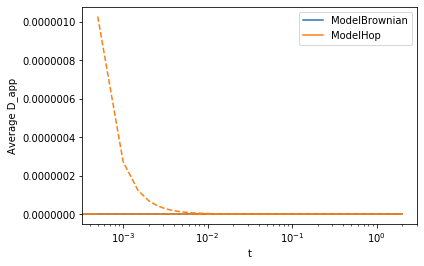

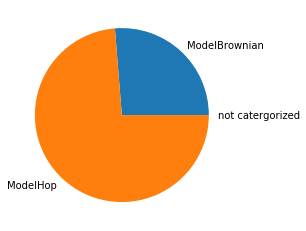

In [22]:
tracks.adc_summary(plot_dapp = True, plot_pie_chart=True)

Now that analysis is done we can also retreive all tracks that fit a certain diffusion category best:

/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: divide by zero encountered in true_divide
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: invalid value encountered in multiply
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))


{'sectors': {'ModelBrownian': 1.0, 'not catergorized': 0.0},
 'average_params': {'ModelBrownian': array([3.40323115e-13, 2.71560061e-08])},
 'average_msd': {'ModelBrownian': array([1.82546758e-15, 2.75913062e-15, 3.63095027e-15, ...,
         2.63871243e-12, 2.60245726e-12, 2.58636679e-12])},
 'average_dapp': {'ModelBrownian': array([1.36910068e-12, 8.27739185e-13, 6.80803175e-13, ...,
         3.30279426e-13, 3.25659956e-13, 3.23565487e-13])}}

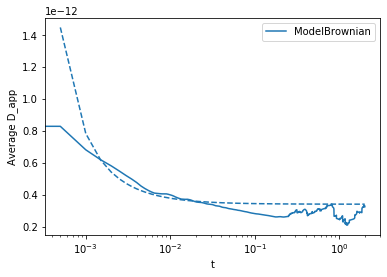

In [27]:
tracks_brownian = tracks.get_sublist(method="adc", model=ModelBrownian)
tracks_brownian.adc_summary(plot_dapp=True)

As mentioned before, we can retreive the analysis results for any track, at any time:

In [28]:
tracks_brownian.get_track(42).get_adc_analysis_results()

{'Dapp': array([5.17508867e-13, 3.83849323e-13, 3.44462863e-13, ...,
        3.20152702e-14, 3.24740666e-14, 3.09546058e-14]),
 'fit_indices': [0, 1, 3, 6, 11, 19, 31, 50, 80],
 'fit_results': {'ModelBrownian': {'params': array([2.25237594e-13, 1.50622912e-08]),
   'errors': array([8.55029201e-15, 6.73555172e-10]),
   'bic': -60.28178076227987,
   'rel_likelihood': 1.0},
  'ModelConfined': {'params': array([3.91995698e-22, 2.38892012e-08, 1.88788678e-15]),
   'errors': array([0.00000000e+00, 4.72057921e-09, 0.00000000e+00]),
   'bic': -56.17006926430937,
   'rel_likelihood': 0.1279832671516896},
  'ModelHop': {'params': array([2.25237594e-13, 2.31517108e-24, 1.50625138e-08, 7.75100910e-05]),
   'errors': array([1.29816878e-14, 1.16708621e-11, 3.65667958e-09, 4.33080701e-25]),
   'bic': -60.281696750381585,
   'rel_likelihood': 0.9999579949330936}},
 'best_model': 'ModelBrownian'}

We can also plot them:

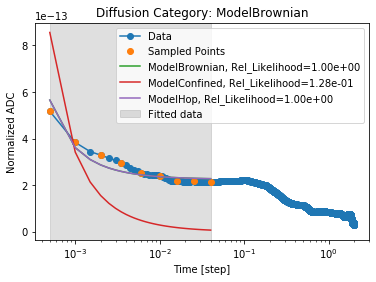

In [29]:
tracks_brownian.get_track(42).plot_adc_analysis_results()